<a href="https://colab.research.google.com/github/DutchVandaline/Artificial_Intelligence/blob/main/GPT2_from_Scratch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Building GPT from scratch.

Building GPT2 is a complex task but I guess I can learn about transformers. For now on, I don't really understand about `attention` and no basics with `RNN`, `LSTM`. It might be a challenging task to understand the transformers of course. But, I have built ViT (Vision Transformer). Why don't I give it a shot?

* References

  * Illustrated-gpt2 by jay alammar : https://jalammar.github.io/illustrated-gpt2/#part-1-got-and-language-modeling
  
  * Here's how you can build and train GPT-2 : https://dev.to/amit_kharel_aae65abe2b111/heres-how-you-can-build-and-train-gpt-2-from-scratch-using-pytorch-345n

I've used jay alammar's blog post to understand the architecture and how gpt2 works and bottom blog post is for dataset and preprocessing.

### 11/15
I want to make GPT from scratch using 140,000 korean article datasets. I've already tokenized using kkma and KR-Bert. GPT needs MaskedMultiHeadSelfAttention, MultiHeadSelfAttention and MultiLayerPerceptron. And, I know how to make 2 of them.

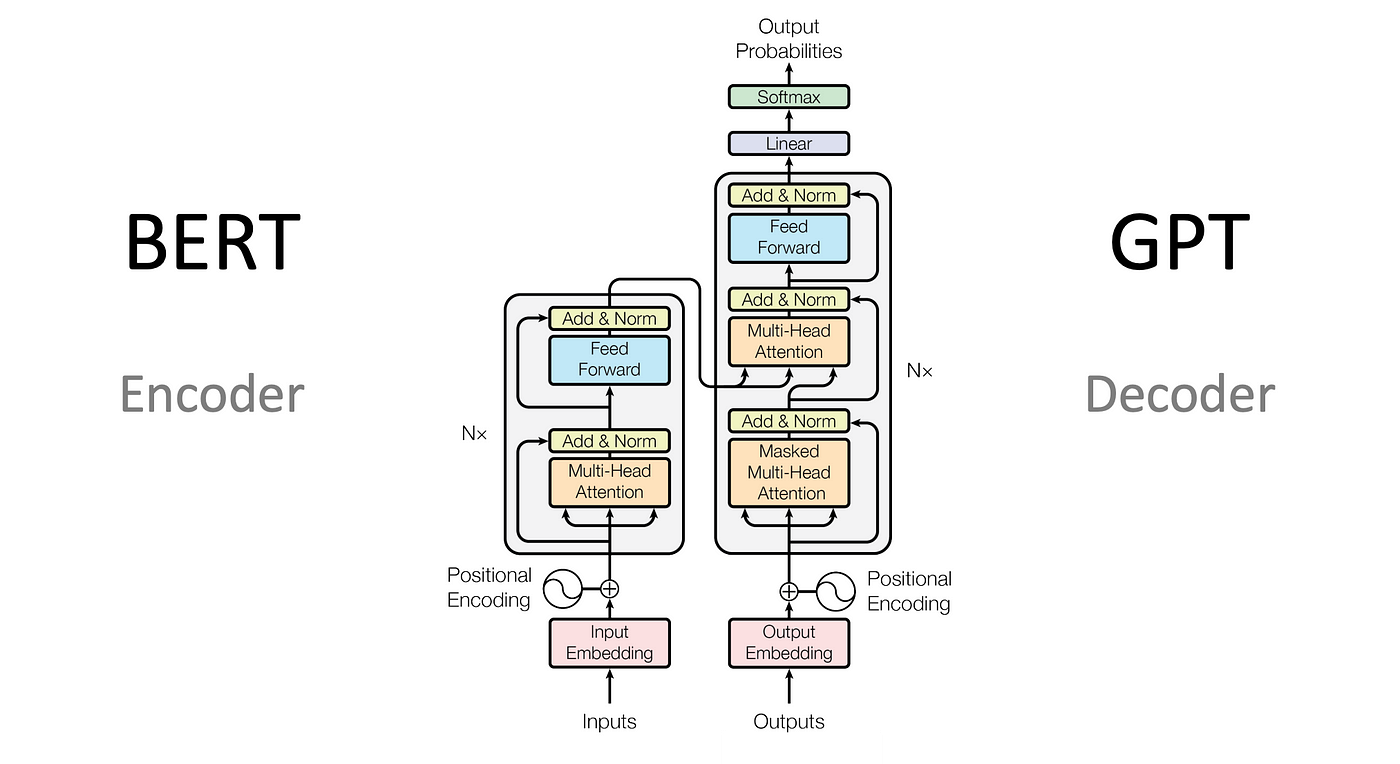



In [ ]:
import torch
import torch.nn
import torchvision

from torch import nn
from torchvision import transforms

import matplotlib.pyplot as plt
print(f"torch version : {torch.__version__}")

torch version: 2.4.0+cpu


In [ ]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cpu'

## Making Transformer Layers

In [ ]:
class MultiHeadSelfAttentionBlock(nn.Module):

  def __init__(self,
               embedding_dim:int=768,
               num_heads:int=12,
               attn_dropout:int=0):

    super().__init__()
    self.layer_norm = nn.LayerNorm(normalized_shape=embedding_dim)

    self.multihead_attn= nn.MultiheadAttention(embed_dim=embedding_dim,
                      num_heads=num_heads,
                      dropout=attn_dropout,
                      batch_first=True)

  def forward(self, x):
    x = self.layer_norm(x)
    attn_output, _ = self.multihead_attn(query=x, # self attention은 qkv모두 같은 vector
                                    key=x,
                                    value=x,
                                    need_weights=False)

    return attn_output


In [ ]:
class MLPBlock(nn.Module):
  def __init__(self,
           embedding_dim:int=768,
           mlp_size:int=3072,
           dropout:float=0.1):
    super().__init__()
    self.layer_norm = nn.LayerNorm(normalized_shape=embedding_dim)
    self.mlp = nn.Sequential(
        nn.Linear(in_features=embedding_dim,
                  out_features=mlp_size),
        nn.GELU(),
        nn.Dropout(p=dropout),
        nn.Linear(in_features=mlp_size,
                  out_features=embedding_dim),
        nn.Dropout(p=dropout))

  def forward(self, x):
    x = self.layer_norm(x)
    x = self.mlp(x)
    return x

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class MaskedMultiHeadSelfAttentionBlock(nn.Module):
    def __init__(self,
                 embedding_dim: int = 768,
                 num_heads: int = 12,
                 attn_dropout: float = 0.1):
        super().__init__()
        self.layer_norm = nn.LayerNorm(embedding_dim)

        self.multihead_attn = nn.MultiheadAttention(embed_dim=embedding_dim,
                                                   num_heads=num_heads,
                                                   dropout=attn_dropout,
                                                   batch_first=True)

    def forward(self, x):
        x = self.layer_norm(x)

        # Masked Self-Attention
        batch_size, seq_len, _ = x.size()

        # Create the mask (upper triangular matrix with -inf for masked positions)
        mask = torch.triu(torch.ones(seq_len, seq_len), diagonal=1).bool().to(x.device)

        # Pass the mask into multihead attention
        attn_output, _ = self.multihead_attn(query=x,
                                             key=x,
                                             value=x,
                                             attn_mask=mask,  # Apply the mask to prevent attending to future tokens
                                             need_weights=False)

        return attn_output


In [ ]:
class TransformerDecoderBlock(nn.Module):
    def __init__(self,
                 embedding_dim: int = 768,
                 num_heads: int = 12,
                 mlp_size: int = 3072,
                 mlp_dropout: float = 0.1,
                 attn_dropout: float = 0.1):
        super().__init__()

        # Create Masked Self-Attention block (for autoregressive behavior)
        self.masked_msa_block = MaskedMultiHeadSelfAttentionBlock(
            embedding_dim=embedding_dim,
            num_heads=num_heads,
            attn_dropout=attn_dropout
        )

        # Create Feed-Forward block (MLP)
        self.mlp_block = MLPBlock(
            embedding_dim=embedding_dim,
            mlp_size=mlp_size,
            dropout=mlp_dropout
        )

        # Layer normalization for each block
        self.layer_norm1 = nn.LayerNorm(embedding_dim)
        self.layer_norm2 = nn.LayerNorm(embedding_dim)

    def forward(self, x):
        # Apply Masked Self-Attention (with residual connection)
        attn_output = self.masked_msa_block(x)
        x = self.layer_norm1(attn_output + x)  # Residual connection + layer normalization

        # Apply Feed-Forward block (MLP) with residual connection
        mlp_output = self.mlp_block(x)
        x = self.layer_norm2(mlp_output + x)  # Residual connection + layer normalization

        return x


In [ ]:
class GPTDecoder(nn.Module):
    def __init__(self,
                 num_layers: int = 12,
                 embedding_dim: int = 768,
                 num_heads: int = 12,
                 mlp_size: int = 3072,
                 mlp_dropout: float = 0.1,
                 attn_dropout: float = 0.1):
        super().__init__()

        # Stack multiple transformer decoder layers
        self.decoder_layers = nn.ModuleList([
            TransformerDecoderBlock(
                embedding_dim=embedding_dim,
                num_heads=num_heads,
                mlp_size=mlp_size,
                mlp_dropout=mlp_dropout,
                attn_dropout=attn_dropout
            ) for _ in range(num_layers)
        ])


    def forward(self, x):
        # Pass through each decoder layer
        for layer in self.decoder_layers:
            x = layer(x)
        return x


In [ ]:
class GPT(nn.Module):
    def __init__(self,
                 vocab_size: int,  # size of the vocabulary
                 num_layers: int = 12,
                 embedding_dim: int = 768,
                 num_heads: int = 12,
                 mlp_size: int = 3072,
                 mlp_dropout: float = 0.1,
                 attn_dropout: float = 0.1):
        super().__init__()

        # Decoder stack
        self.decoder = GPTDecoder(
            num_layers=num_layers,
            embedding_dim=embedding_dim,
            num_heads=num_heads,
            mlp_size=mlp_size,
            mlp_dropout=mlp_dropout,
            attn_dropout=attn_dropout
        )

        # Output layer
        self.output_layer = nn.Linear(embedding_dim, vocab_size)

    def forward(self, x):
        # Pass through the decoder stack
        x = self.decoder(x)

        # Pass through the output layer to get predictions
        logits = self.output_layer(x)
        return logits


In [ ]:
def generate(model, input_ids, max_length=50):
    model.eval()  # Switch to evaluation mode
    generated = input_ids

    for _ in range(max_length):
        # Forward pass through the model
        logits = model(generated)

        # Get the logits for the last token (next token prediction)
        next_token_logits = logits[:, -1, :]  # The last token in the sequence

        # Apply softmax to get probabilities
        probabilities = torch.softmax(next_token_logits, dim=-1)

        # Sample from the distribution or pick the most likely token
        next_token = torch.argmax(probabilities, dim=-1)

        # Append the next token to the input sequence
        generated = torch.cat((generated, next_token.unsqueeze(1)), dim=1)

    return generated


In [ ]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-4, weight_decay=0.01)

In [ ]:
import torch
from torch.utils.data import DataLoader, TensorDataset

# Assume that you have tokenized your data and have the tokenized PT files.
# Assuming 'train_dataset' contains tokenized sequences and 'train_loader' is the DataLoader
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)

def train(model, train_loader, optimizer, criterion, device):
    model.train()
    total_loss = 0

    for batch in train_loader:
        input_ids = batch['input_ids'].to(device)
        labels = input_ids  # For causal language modeling, labels are the same as input

        optimizer.zero_grad()
        # Forward pass
        logits = model(input_ids)

        # Calculate the loss
        loss = criterion(logits.view(-1, logits.size(-1)), labels.view(-1))
        total_loss += loss.item()

        # Backward pass and optimization
        loss.backward()
        optimizer.step()

    return total_loss / len(train_loader)

# Instantiate model, optimizer
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = GPT(vocab_size=len(vocab), num_layers=12, embedding_dim=768, num_heads=12, mlp_size=3072, mlp_dropout=0.1, attn_dropout=0.1).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)

# Training loop
for epoch in range(num_epochs):
    avg_loss = train(model, train_loader, optimizer, criterion, device)
    print(f'Epoch {epoch+1}/{num_epochs}, Loss: {avg_loss}')
